In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -R '/content/drive/MyDrive/AI/SpineXR_Lesions_Dectection' '/drive/MyDrive/AI'

In [ ]:
#Install requirements
!pip install super-gradients==3.1.0
!pip install imutils

!pip install roboflow

!pip install pytube --upgrade

In [ ]:
#get data
!gdown 1-3JOV67ee7JmyRFiaHq6jEgkw4j6JyGo
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/data/labels/test/d4dd6e89a73ce4c1d7f16562b535df16.txt  
  inflating: content/data/labels/test/998554daa9553b1d76e582da9ab0416c.txt  
  inflating: content/data/labels/test/2cfb0d8b66f4b7452e6fe7ba090d7ca0.txt  
  inflating: content/data/labels/test/a6380559f7e630b0b1f1fbdeb4a85fb3.txt  
  inflating: content/data/labels/test/e4122d6b1efc7266329f0ab5db456924.txt  
  inflating: content/data/labels/test/4481ae5cfe33c0958bae66c5ba672b58.txt  
  inflating: content/data/labels/test/cdd5f1cc9bdd42a9ee7e106496dc9595.txt  
  inflating: content/data/labels/test/9192a01e564966cf512a1770648048dd.txt  
  inflating: content/data/labels/test/cacd20102ae5ca48207211c5f4c0ec60.txt  
  inflating: content/data/labels/test/be6b4dd7edffa814c0d1e35e50099eb6.txt  
  inflating: content/data/labels/test/e56b5bc0a1715a6114b8f166e4154306.txt  
  inflating: content/data/labels/test/24f2987c0cb86c2ff9f6efa0ae43d7f0.txt  
  inflating: content/data

## **Init Trainer**

In [ ]:
from super_gradients.training import Trainer
import torch
CHECKPOINT_DIR = '/content/drive/MyDrive/AI'
trainer = Trainer(experiment_name='SpineXR_Lesions_Dectection', ckpt_root_dir=CHECKPOINT_DIR)

[2023-06-05 11:32:23] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-05 11:32:29] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-05 11:32:29] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-05 11:32:29] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-05 11:32:29] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Datasets and Dataloaders

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
data_list= os.listdir('/content/yolo/train')
df_data= pd.DataFrame(data_list, columns=['file_name'])

[2023-05-31 13:34:07] INFO - utils.py - NumExpr defaulting to 2 threads.


FileNotFoundError: ignored

In [ ]:
#Using GroupKFold (n=5) to splid trainset with first 4 folds is train, last-fold is val
gkf  = GroupKFold(n_splits = 5)
for fold, (train_idx, val_idx) in enumerate(gkf.split(df_data, groups = df_data.file_name.tolist())):
    df_data.loc[val_idx, 'fold'] = fold
df_data.head()

### Split train/valid

In [ ]:
train_files = []
val_files   = []
val_files += list(df_data[df_data.fold==fold].file_name.unique())
train_files += list(df_data[df_data.fold!=fold].file_name.unique())
len(train_files), len(val_files)

(3441, 688)

In [ ]:
import shutil

In [ ]:
#split into 2 folder
dest_path= 'data/yolo'
os.makedirs('data/yolo/train/labels', exist_ok = True)
os.makedirs('data/yolo/val/labels', exist_ok = True)
os.makedirs('data/yolo/train/images', exist_ok = True)
os.makedirs('data/yolo/val/images', exist_ok = True)
label_dir = 'yolo/'
image_dir = 'data'

count_train=[]
count_val=[]
for file in tqdm(train_files):
    filename = file.split('.')[0]
    try:
      shutil.copy(os.path.join(image_dir, "train_pngs", filename +'.png'), os.path.join(dest_path, "train","images"))
      shutil.copy(os.path.join(label_dir, "train", file), os.path.join(dest_path, "train","labels"))
    except:
      count_train.append(file)
for file in tqdm(val_files):
    filename = file.split('/')[-1].split('.')[0]
    try:
      shutil.copy(os.path.join(image_dir, "train_pngs", filename +'.png'), os.path.join(dest_path, "val", "images"))
      shutil.copy(os.path.join(label_dir, "train",file), os.path.join(dest_path, "val", "labels"))
    except:
      count_val.append(file)

 99%|█████████▉| 680/688 [00:11<00:00, 59.64it/s]

In [ ]:
count_val

['24b8c8688a2676ddc7516d2f635d2707.txt',
 '02680e025fdbdf8f197bbe479f256856.txt',
 '5b91fcc2f583fee4a38be734ecb507b0.txt',
 '8438b2b912767ab85c98be410f862c97.txt',
 '762fdcc14c4f0db5f4f2bb630c3152ba.txt',
 '7f358d06720ada0f9f34bfc4a5a869c7.txt',
 '2f1aac64c09073af00d52bfd756cb899.txt',
 '21e96bfda7e11446941ff5bb918bec62.txt',
 '512b349d6a4b0695b42b46a9cc72afa4.txt',
 '4ca4951a4efc4e3f8cf6ba82178ac532.txt',
 '39a59e44b3f69ae5a179107340461e11.txt',
 'bd03cd63e51ace341559c528dfeeaf0f.txt',
 '9299629fd0e02356d6ce43dd4311fef7.txt']

In [ ]:
CLASSES = ["Disc space narrowing", "Foraminal stenosis", "Osteophytes", "Other lesions", "Spondylolysthesis", "Surgical implant", "Vertebral collapse"]
dataset_params = {
    'data_dir': 'data/yolo',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'val/images',
    'val_labels_dir':'val/labels',
    # 'test_images_dir':'test/images',
    # 'test_labels_dir':'test/labels',
    'classes': CLASSES
}

from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes'],
        'cache': true,
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

# test_data = coco_detection_yolo_format_val(
#     dataset_params={
#         'data_dir': dataset_params['data_dir'],
#         'images_dir': dataset_params['test_images_dir'],
#         'labels_dir': dataset_params['test_labels_dir'],
#         'classes': dataset_params['classes']
#     },
#     dataloader_params={
#         'batch_size':16,
#         'num_workers':2
#     }
#)

clear_output()

NameError: ignored

Caching annotations: 100%|██████████| 675/675 [00:00<00:00, 5051.34it/s]


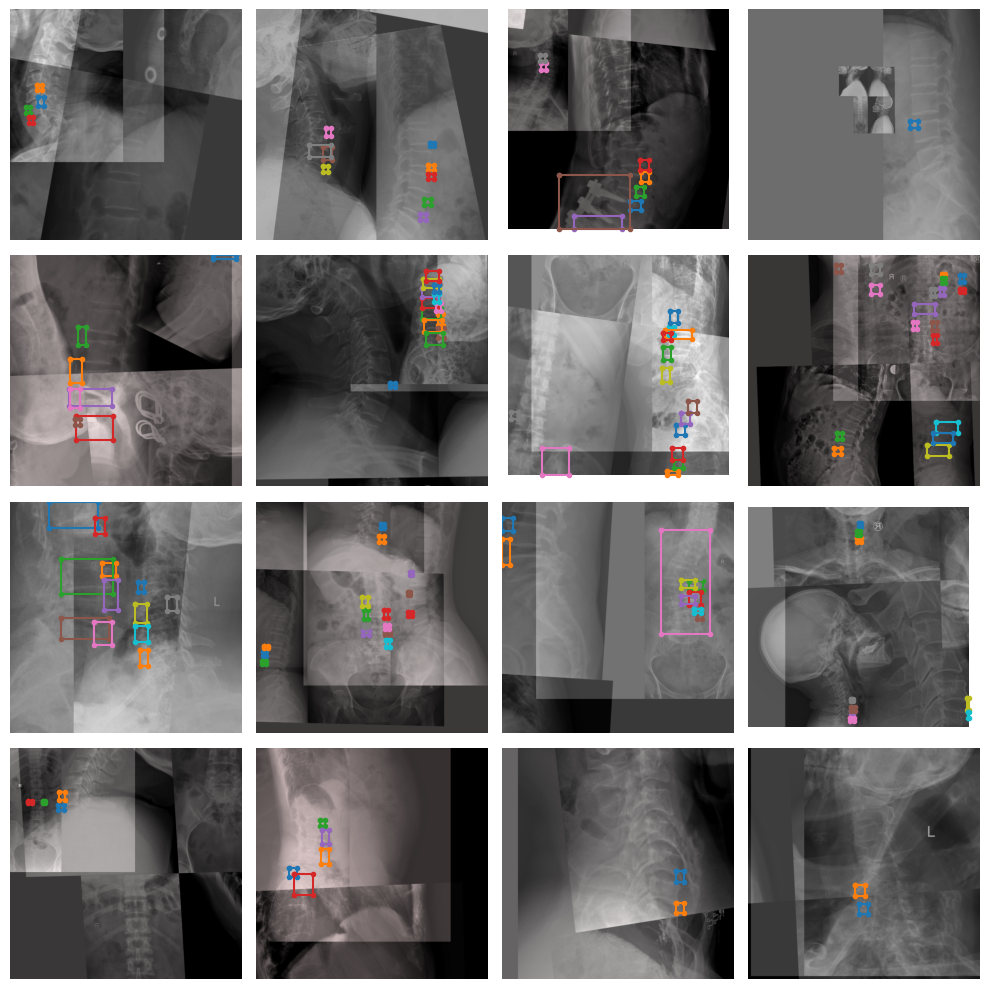

In [ ]:
train_data.dataset.plot()

## Instantiating the model

In [ ]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

#CREATE DATASET
CLASSES = ["Disc space narrowing", "Foraminal stenosis", "Osteophytes", "Other lesions", "Spondylolysthesis", "Surgical implant", "Vertebral collapse"]
dataset_params = {
    'data_dir': 'content/data/',
    'train_images_dir':'images/train',
    'train_labels_dir':'labels/train',
    'val_images_dir':'images/val',
    'val_labels_dir':'labels/val',
    'test_images_dir':'images/test',
    'test_labels_dir':'labels/test',
    'classes': CLASSES
}

from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [ ]:
from super_gradients.training import models
#Load coco_pretrained model
# model = models.get('yolo_nas_l',
#                    num_classes=len(dataset_params['classes']),
#                    pretrained_weights="coco"
#                    )

#load final model
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   checkpoint_path='/content/drive/MyDrive/AI/SpineXR_Lesions_Dectection/ckpt_best.pth'
                   )

Caching annotations: 100%|██████████| 873/873 [00:00<00:00, 2608.61it/s]
[2023-06-05 11:32:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/AI/SpineXR_Lesions_Dectection/ckpt_best.pth EMA checkpoint.


In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050, DetectionMetrics
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

#config trainer

train_params = {
    'silent_mode': False,
    'resume': True,
    'resume_path': '/content/drive/MyDrive/AI/SpineXR_Lesions_Dectection/ckpt_latest.pth',
    'ckpt_best_name': '/content/drive/MyDrive/AI/SpineXR_Lesions_Dectection/ckpt_best.pth',
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 170,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50',
    "cache": True
}

## Training model

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()


In [ ]:
#Training
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-06-03 18:24:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/AI/SpineXR_Lesions_Dectection/ckpt_latest.pth checkpoint.
[2023-06-03 18:24:38] WARNING - sg_trainer.py - [WARNING] Main network has been loaded from checkpoint but EMA network exists as well. It  will only be loaded during validation when training with ema=True. 
[2023-06-03 18:24:38] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-06-03 18:24:42] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to /content/drive/MyDrive/AI/SpineXR_Lesions_Dectection/console_Jun03_18_24_43.txt


[2023-06-03 18:25:05] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 3258       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         203        (len(train_loader))
    - Gradient updates per epoch:   203        (len(train_loader) / batch_accumulate)

[2023-06-03 18:25:05] INFO - sg_trainer.py - Started training for 52 epochs (118/169)

Validation epoch 118: 100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


SUMMARY OF EPOCH 118
├── Training
│   ├── Ppyoloeloss/loss = 2.1032
│   ├── Ppyoloeloss/loss_cls = 0.9965
│   ├── Ppyoloeloss/loss_dfl = 0.858
│   └── Ppyoloeloss/loss_iou = 0.2711
└── Validation
    ├── F1@0.50 = 0.1066
    ├── Map@0.50 = 0.5824
    ├── Ppyoloeloss/loss = 2.0234
    ├── Ppyoloeloss/loss_cls = 0.9526
    ├── Ppyoloeloss/loss_dfl = 0.8215
    ├── Ppyoloeloss/loss_iou = 0.264
    ├── Precision@0.50 = 0.0573
    └── Recall@0.50 = 0.8805



Validation epoch 119: 100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


SUMMARY OF EPOCH 119
├── Training
│   ├── Ppyoloeloss/loss = 2.1069
│   │   ├── Best until now = 2.1032 (↗ 0.0037)
│   │   └── Epoch N-1      = 2.1032 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_cls = 1.0001
│   │   ├── Best until now = 0.9965 (↗ 0.0036)
│   │   └── Epoch N-1      = 0.9965 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.8621
│   │   ├── Best until now = 0.858  (↗ 0.0041)
│   │   └── Epoch N-1      = 0.858  (↗ 0.0041)
│   └── Ppyoloeloss/loss_iou = 0.2703
│       ├── Best until now = 0.2711 (↘ -0.0008)
│       └── Epoch N-1      = 0.2711 (↘ -0.0008)
└── Validation
    ├── F1@0.50 = 0.0843
    │   ├── Best until now = 0.1066 (↘ -0.0223)
    │   └── Epoch N-1      = 0.1066 (↘ -0.0223)
    ├── Map@0.50 = 0.5462
    │   ├── Best until now = 0.5824 (↘ -0.0362)
    │   └── Epoch N-1      = 0.5824 (↘ -0.0362)
    ├── Ppyoloeloss/loss = 2.1272
    │   ├── Best until now = 2.0234 (↗ 0.1038)
    │   └── Epoch N-1      = 2.0234 (↗ 0.1038)
    ├── Ppyoloeloss/loss_cls = 1.0171
    │   ├── Best

Validation epoch 120: 100%|██████████| 51/51 [00:56<00:00,  1.10s/it]


SUMMARY OF EPOCH 120
├── Training
│   ├── Ppyoloeloss/loss = 2.113
│   │   ├── Best until now = 2.1032 (↗ 0.0098)
│   │   └── Epoch N-1      = 2.1069 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_cls = 0.9991
│   │   ├── Best until now = 0.9965 (↗ 0.0026)
│   │   └── Epoch N-1      = 1.0001 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.8636
│   │   ├── Best until now = 0.858  (↗ 0.0056)
│   │   └── Epoch N-1      = 0.8621 (↗ 0.0015)
│   └── Ppyoloeloss/loss_iou = 0.2728
│       ├── Best until now = 0.2703 (↗ 0.0025)
│       └── Epoch N-1      = 0.2703 (↗ 0.0025)
└── Validation
    ├── F1@0.50 = 0.1036
    │   ├── Best until now = 0.1066 (↘ -0.0031)
    │   └── Epoch N-1      = 0.0843 (↗ 0.0192)
    ├── Map@0.50 = 0.5522
    │   ├── Best until now = 0.5824 (↘ -0.0301)
    │   └── Epoch N-1      = 0.5462 (↗ 0.006)
    ├── Ppyoloeloss/loss = 2.0763
    │   ├── Best until now = 2.0234 (↗ 0.0529)
    │   └── Epoch N-1      = 2.1272 (↘ -0.0508)
    ├── Ppyoloeloss/loss_cls = 0.9907
    │   ├── Best unti

Validation epoch 121: 100%|██████████| 51/51 [00:55<00:00,  1.09s/it]


SUMMARY OF EPOCH 121
├── Training
│   ├── Ppyoloeloss/loss = 2.0947
│   │   ├── Best until now = 2.1032 (↘ -0.0085)
│   │   └── Epoch N-1      = 2.113  (↘ -0.0183)
│   ├── Ppyoloeloss/loss_cls = 0.9939
│   │   ├── Best until now = 0.9965 (↘ -0.0026)
│   │   └── Epoch N-1      = 0.9991 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.8533
│   │   ├── Best until now = 0.858  (↘ -0.0047)
│   │   └── Epoch N-1      = 0.8636 (↘ -0.0104)
│   └── Ppyoloeloss/loss_iou = 0.2697
│       ├── Best until now = 0.2703 (↘ -0.0006)
│       └── Epoch N-1      = 0.2728 (↘ -0.0032)
└── Validation
    ├── F1@0.50 = 0.1041
    │   ├── Best until now = 0.1066 (↘ -0.0025)
    │   └── Epoch N-1      = 0.1036 (↗ 0.0005)
    ├── Map@0.50 = 0.524
    │   ├── Best until now = 0.5824 (↘ -0.0584)
    │   └── Epoch N-1      = 0.5522 (↘ -0.0282)
    ├── Ppyoloeloss/loss = 2.1129
    │   ├── Best until now = 2.0234 (↗ 0.0895)
    │   └── Epoch N-1      = 2.0763 (↗ 0.0366)
    ├── Ppyoloeloss/loss_cls = 1.017
    │   ├── B

Validation epoch 122: 100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


SUMMARY OF EPOCH 122
├── Training
│   ├── Ppyoloeloss/loss = 2.1014
│   │   ├── Best until now = 2.0947 (↗ 0.0067)
│   │   └── Epoch N-1      = 2.0947 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_cls = 0.9946
│   │   ├── Best until now = 0.9939 (↗ 0.0007)
│   │   └── Epoch N-1      = 0.9939 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.8595
│   │   ├── Best until now = 0.8533 (↗ 0.0062)
│   │   └── Epoch N-1      = 0.8533 (↗ 0.0062)
│   └── Ppyoloeloss/loss_iou = 0.2708
│       ├── Best until now = 0.2697 (↗ 0.0012)
│       └── Epoch N-1      = 0.2697 (↗ 0.0012)
└── Validation
    ├── F1@0.50 = 0.0914
    │   ├── Best until now = 0.1066 (↘ -0.0152)
    │   └── Epoch N-1      = 0.1041 (↘ -0.0127)
    ├── Map@0.50 = 0.5452
    │   ├── Best until now = 0.5824 (↘ -0.0372)
    │   └── Epoch N-1      = 0.524  (↗ 0.0212)
    ├── Ppyoloeloss/loss = 2.0861
    │   ├── Best until now = 2.0234 (↗ 0.0627)
    │   └── Epoch N-1      = 2.1129 (↘ -0.0268)
    ├── Ppyoloeloss/loss_cls = 0.9965
    │   ├── Best u

Validation epoch 123: 100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


SUMMARY OF EPOCH 123
├── Training
│   ├── Ppyoloeloss/loss = 2.0859
│   │   ├── Best until now = 2.0947 (↘ -0.0087)
│   │   └── Epoch N-1      = 2.1014 (↘ -0.0155)
│   ├── Ppyoloeloss/loss_cls = 0.9841
│   │   ├── Best until now = 0.9939 (↘ -0.0098)
│   │   └── Epoch N-1      = 0.9946 (↘ -0.0105)
│   ├── Ppyoloeloss/loss_dfl = 0.8556
│   │   ├── Best until now = 0.8533 (↗ 0.0024)
│   │   └── Epoch N-1      = 0.8595 (↘ -0.0039)
│   └── Ppyoloeloss/loss_iou = 0.2696
│       ├── Best until now = 0.2697 (↘ -0.0)
│       └── Epoch N-1      = 0.2708 (↘ -0.0012)
└── Validation
    ├── F1@0.50 = 0.1248
    │   ├── Best until now = 0.1066 (↗ 0.0181)
    │   └── Epoch N-1      = 0.0914 (↗ 0.0334)
    ├── Map@0.50 = 0.5488
    │   ├── Best until now = 0.5824 (↘ -0.0336)
    │   └── Epoch N-1      = 0.5452 (↗ 0.0036)
    ├── Ppyoloeloss/loss = 2.056
    │   ├── Best until now = 2.0234 (↗ 0.0326)
    │   └── Epoch N-1      = 2.0861 (↘ -0.0301)
    ├── Ppyoloeloss/loss_cls = 0.9688
    │   ├── Best 

Validation epoch 124: 100%|██████████| 51/51 [00:56<00:00,  1.10s/it]


SUMMARY OF EPOCH 124
├── Training
│   ├── Ppyoloeloss/loss = 2.0948
│   │   ├── Best until now = 2.0859 (↗ 0.0088)
│   │   └── Epoch N-1      = 2.0859 (↗ 0.0088)
│   ├── Ppyoloeloss/loss_cls = 0.9897
│   │   ├── Best until now = 0.9841 (↗ 0.0056)
│   │   └── Epoch N-1      = 0.9841 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.8619
│   │   ├── Best until now = 0.8533 (↗ 0.0087)
│   │   └── Epoch N-1      = 0.8556 (↗ 0.0063)
│   └── Ppyoloeloss/loss_iou = 0.2696
│       ├── Best until now = 0.2696 (↗ 0.0)
│       └── Epoch N-1      = 0.2696 (↗ 0.0)
└── Validation
    ├── F1@0.50 = 0.1209
    │   ├── Best until now = 0.1248 (↘ -0.0039)
    │   └── Epoch N-1      = 0.1248 (↘ -0.0039)
    ├── Map@0.50 = 0.5802
    │   ├── Best until now = 0.5824 (↘ -0.0022)
    │   └── Epoch N-1      = 0.5488 (↗ 0.0314)
    ├── Ppyoloeloss/loss = 2.0367
    │   ├── Best until now = 2.0234 (↗ 0.0133)
    │   └── Epoch N-1      = 2.056  (↘ -0.0193)
    ├── Ppyoloeloss/loss_cls = 0.9586
    │   ├── Best until n

Validation epoch 125: 100%|██████████| 51/51 [00:55<00:00,  1.09s/it]


SUMMARY OF EPOCH 125
├── Training
│   ├── Ppyoloeloss/loss = 2.0901
│   │   ├── Best until now = 2.0859 (↗ 0.0042)
│   │   └── Epoch N-1      = 2.0948 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_cls = 0.9884
│   │   ├── Best until now = 0.9841 (↗ 0.0043)
│   │   └── Epoch N-1      = 0.9897 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.8577
│   │   ├── Best until now = 0.8533 (↗ 0.0044)
│   │   └── Epoch N-1      = 0.8619 (↘ -0.0043)
│   └── Ppyoloeloss/loss_iou = 0.2691
│       ├── Best until now = 0.2696 (↘ -0.0005)
│       └── Epoch N-1      = 0.2696 (↘ -0.0005)
└── Validation
    ├── F1@0.50 = 0.1062
    │   ├── Best until now = 0.1248 (↘ -0.0186)
    │   └── Epoch N-1      = 0.1209 (↘ -0.0147)
    ├── Map@0.50 = 0.5799
    │   ├── Best until now = 0.5824 (↘ -0.0025)
    │   └── Epoch N-1      = 0.5802 (↘ -0.0003)
    ├── Ppyoloeloss/loss = 2.0612
    │   ├── Best until now = 2.0234 (↗ 0.0378)
    │   └── Epoch N-1      = 2.0367 (↗ 0.0244)
    ├── Ppyoloeloss/loss_cls = 0.9609
    │   ├── B

Validation epoch 126: 100%|██████████| 51/51 [00:55<00:00,  1.08s/it]


SUMMARY OF EPOCH 126
├── Training
│   ├── Ppyoloeloss/loss = 2.0905
│   │   ├── Best until now = 2.0859 (↗ 0.0046)
│   │   └── Epoch N-1      = 2.0901 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_cls = 0.9894
│   │   ├── Best until now = 0.9841 (↗ 0.0053)
│   │   └── Epoch N-1      = 0.9884 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.8591
│   │   ├── Best until now = 0.8533 (↗ 0.0059)
│   │   └── Epoch N-1      = 0.8577 (↗ 0.0015)
│   └── Ppyoloeloss/loss_iou = 0.2686
│       ├── Best until now = 0.2691 (↘ -0.0005)
│       └── Epoch N-1      = 0.2691 (↘ -0.0005)
└── Validation
    ├── F1@0.50 = 0.0969
    │   ├── Best until now = 0.1248 (↘ -0.0279)
    │   └── Epoch N-1      = 0.1062 (↘ -0.0093)
    ├── Map@0.50 = 0.5545
    │   ├── Best until now = 0.5824 (↘ -0.0279)
    │   └── Epoch N-1      = 0.5799 (↘ -0.0254)
    ├── Ppyoloeloss/loss = 2.1154
    │   ├── Best until now = 2.0234 (↗ 0.092)
    │   └── Epoch N-1      = 2.0612 (↗ 0.0543)
    ├── Ppyoloeloss/loss_cls = 1.0103
    │   ├── Best u

Validation epoch 127: 100%|██████████| 51/51 [00:55<00:00,  1.08s/it]


SUMMARY OF EPOCH 127
├── Training
│   ├── Ppyoloeloss/loss = 2.0855
│   │   ├── Best until now = 2.0859 (↘ -0.0004)
│   │   └── Epoch N-1      = 2.0905 (↘ -0.005)
│   ├── Ppyoloeloss/loss_cls = 0.9868
│   │   ├── Best until now = 0.9841 (↗ 0.0027)
│   │   └── Epoch N-1      = 0.9894 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.8526
│   │   ├── Best until now = 0.8533 (↘ -0.0006)
│   │   └── Epoch N-1      = 0.8591 (↘ -0.0065)
│   └── Ppyoloeloss/loss_iou = 0.269
│       ├── Best until now = 0.2686 (↗ 0.0003)
│       └── Epoch N-1      = 0.2686 (↗ 0.0003)
└── Validation
    ├── F1@0.50 = 0.1239
    │   ├── Best until now = 0.1248 (↘ -0.0009)
    │   └── Epoch N-1      = 0.0969 (↗ 0.027)
    ├── Map@0.50 = 0.5856
    │   ├── Best until now = 0.5824 (↗ 0.0032)
    │   └── Epoch N-1      = 0.5545 (↗ 0.0311)
    ├── Ppyoloeloss/loss = 2.0517
    │   ├── Best until now = 2.0234 (↗ 0.0283)
    │   └── Epoch N-1      = 2.1154 (↘ -0.0637)
    ├── Ppyoloeloss/loss_cls = 0.9613
    │   ├── Best u

Validation epoch 128: 100%|██████████| 51/51 [00:55<00:00,  1.08s/it]


SUMMARY OF EPOCH 128
├── Training
│   ├── Ppyoloeloss/loss = 2.0853
│   │   ├── Best until now = 2.0855 (↘ -0.0002)
│   │   └── Epoch N-1      = 2.0855 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_cls = 0.9885
│   │   ├── Best until now = 0.9841 (↗ 0.0044)
│   │   └── Epoch N-1      = 0.9868 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.8523
│   │   ├── Best until now = 0.8526 (↘ -0.0003)
│   │   └── Epoch N-1      = 0.8526 (↘ -0.0003)
│   └── Ppyoloeloss/loss_iou = 0.2683
│       ├── Best until now = 0.2686 (↘ -0.0004)
│       └── Epoch N-1      = 0.269  (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.1215
    │   ├── Best until now = 0.1248 (↘ -0.0033)
    │   └── Epoch N-1      = 0.1239 (↘ -0.0024)
    ├── Map@0.50 = 0.5929
    │   ├── Best until now = 0.5856 (↗ 0.0074)
    │   └── Epoch N-1      = 0.5856 (↗ 0.0074)
    ├── Ppyoloeloss/loss = 2.0251
    │   ├── Best until now = 2.0234 (↗ 0.0017)
    │   └── Epoch N-1      = 2.0517 (↘ -0.0266)
    ├── Ppyoloeloss/loss_cls = 0.9622
    │   ├── B

Validation epoch 129: 100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


SUMMARY OF EPOCH 129
├── Training
│   ├── Ppyoloeloss/loss = 2.08
│   │   ├── Best until now = 2.0853 (↘ -0.0053)
│   │   └── Epoch N-1      = 2.0853 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_cls = 0.9826
│   │   ├── Best until now = 0.9841 (↘ -0.0015)
│   │   └── Epoch N-1      = 0.9885 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.8534
│   │   ├── Best until now = 0.8523 (↗ 0.0011)
│   │   └── Epoch N-1      = 0.8523 (↗ 0.0011)
│   └── Ppyoloeloss/loss_iou = 0.2683
│       ├── Best until now = 0.2683 (↗ 0.0)
│       └── Epoch N-1      = 0.2683 (↗ 0.0)
└── Validation
    ├── F1@0.50 = 0.1139
    │   ├── Best until now = 0.1248 (↘ -0.0109)
    │   └── Epoch N-1      = 0.1215 (↘ -0.0076)
    ├── Map@0.50 = 0.5845
    │   ├── Best until now = 0.5929 (↘ -0.0084)
    │   └── Epoch N-1      = 0.5929 (↘ -0.0084)
    ├── Ppyoloeloss/loss = 2.0424
    │   ├── Best until now = 2.0234 (↗ 0.019)
    │   └── Epoch N-1      = 2.0251 (↗ 0.0173)
    ├── Ppyoloeloss/loss_cls = 0.9535
    │   ├── Best until 

Train epoch 130:  30%|██▉       | 60/203 [04:41<10:56,  4.59s/it, PPYoloELoss/loss=2.09, PPYoloELoss/loss_cls=0.993, PPYoloELoss/loss_dfl=0.854, PPYoloELoss/loss_iou=0.267, gpu_mem=13]


# Evaluate


In [ ]:
from typing import Dict, Optional, Union
import torch
from torchmetrics import Metric

import super_gradients
from super_gradients.common.object_names import Metrics
from super_gradients.common.registry.registry import register_metric
from super_gradients.training.utils import tensor_container_to_device
from super_gradients.training.utils.detection_utils import compute_detection_matching, compute_detection_metrics
from super_gradients.training.utils.detection_utils import DetectionPostPredictionCallback, IouThreshold
from super_gradients.common.abstractions.abstract_logger import get_logger

logger = get_logger(__name__)

#Define DetectionMetrics
class DetectionMetrics(Metric):
    """
    DetectionMetrics

    Metric class for computing F1, Precision, Recall and Mean Average Precision.

    :param num_cls:                         Number of classes.
    :param post_prediction_callback:        DetectionPostPredictionCallback to be applied on net's output prior to the metric computation (NMS).
    :param normalize_targets:               Whether to normalize bbox coordinates by image size.
    :param iou_thres:                       IoU threshold to compute the mAP.
    :param recall_thres:                    Recall threshold to compute the mAP.
    :param score_thres:                     Score threshold to compute Recall, Precision and F1.
    :param top_k_predictions:               Number of predictions per class used to compute metrics, ordered by confidence score
    :param dist_sync_on_step:               Synchronize metric state across processes at each ``forward()`` before returning the value at the step.
    :param accumulate_on_cpu:               Run on CPU regardless of device used in other parts.
                                            This is to avoid "CUDA out of memory" that might happen on GPU.
    """

    def __init__(
        self,
        num_cls: int,
        post_prediction_callback: DetectionPostPredictionCallback,
        normalize_targets: bool = False,
        iou_thres: Union[IouThreshold, float] = IouThreshold.MAP_05_TO_095,
        recall_thres: torch.Tensor = None,
        score_thres: float = 0.1,
        top_k_predictions: int = 100,
        dist_sync_on_step: bool = False,
        accumulate_on_cpu: bool = True,
    ):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.num_cls = num_cls
        self.iou_thres = iou_thres

        if isinstance(iou_thres, IouThreshold):
            self.iou_thresholds = iou_thres.to_tensor()
        else:
            self.iou_thresholds = torch.tensor([iou_thres])

        self.map_str = "mAP" + self._get_range_str()
        self.greater_component_is_better = {
            f"Precision{self._get_range_str()}": True,
            f"Recall{self._get_range_str()}": True,
            f"mAP{self._get_range_str()}": True,
            f"F1{self._get_range_str()}": True,
        }
        self.component_names = list(self.greater_component_is_better.keys())
        self.components = len(self.component_names)

        self.post_prediction_callback = post_prediction_callback
        self.is_distributed = super_gradients.is_distributed()
        self.denormalize_targets = not normalize_targets
        self.world_size = None
        self.rank = None
        self.add_state(f"matching_info{self._get_range_str()}", default=[], dist_reduce_fx=None)

        self.recall_thresholds = torch.linspace(0, 1, 101) if recall_thres is None else recall_thres
        self.score_threshold = score_thres
        self.top_k_predictions = top_k_predictions
        self.ap=None
        self.accumulate_on_cpu = accumulate_on_cpu

    def update(self, preds, target: torch.Tensor, device: str, inputs: torch.tensor, crowd_targets: Optional[torch.Tensor] = None) -> None:
        """
        Apply NMS and match all the predictions and targets of a given batch, and update the metric state accordingly.

        :param preds:           Raw output of the model, the format might change from one model to another,
                                but has to fit the input format of the post_prediction_callback (cx,cy,wh)
        :param target:          Targets for all images of shape (total_num_targets, 6) LABEL_CXCYWH. format:  (index, label, cx, cy, w, h)
        :param device:          Device to run on
        :param inputs:          Input image tensor of shape (batch_size, n_img, height, width)
        :param crowd_targets:   Crowd targets for all images of shape (total_num_targets, 6), LABEL_CXCYWH
        """
        self.iou_thresholds = self.iou_thresholds.to(device)
        _, _, height, width = inputs.shape

        targets = target.clone()
        crowd_targets = torch.zeros(size=(0, 6), device=device) if crowd_targets is None else crowd_targets.clone()

        preds = self.post_prediction_callback(preds, device=device)

        new_matching_info = compute_detection_matching(
            preds,
            targets,
            height,
            width,
            self.iou_thresholds,
            crowd_targets=crowd_targets,
            top_k=self.top_k_predictions,
            denormalize_targets=self.denormalize_targets,
            device=self.device,
            return_on_cpu=self.accumulate_on_cpu,
        )

        accumulated_matching_info = getattr(self, f"matching_info{self._get_range_str()}")
        setattr(self, f"matching_info{self._get_range_str()}", accumulated_matching_info + new_matching_info)

    def compute(self) -> Dict[str, Union[float, torch.Tensor]]:
        """Compute the metrics for all the accumulated results.
        :return: Metrics of interest
        """
        mean_ap, mean_precision, mean_recall, mean_f1 = -1.0, -1.0, -1.0, -1.0
        accumulated_matching_info = getattr(self, f"matching_info{self._get_range_str()}")

        if len(accumulated_matching_info):
            matching_info_tensors = [torch.cat(x, 0) for x in list(zip(*accumulated_matching_info))]

            # shape (n_class, nb_iou_thresh)
            ap, precision, recall, f1, unique_classes = compute_detection_metrics(
                *matching_info_tensors,
                recall_thresholds=self.recall_thresholds,
                score_threshold=self.score_threshold,
                device="cpu" if self.accumulate_on_cpu else self.device,
            )

            # Precision, recall and f1 are computed for IoU threshold range, averaged over classes
            # results before version 3.0.4 (Dec 11 2022) were computed only for smallest value (i.e IoU 0.5 if metric is @0.5:0.95)
            mean_precision, mean_recall, mean_f1 = precision.mean(), recall.mean(), f1.mean()

            # MaP is averaged over IoU thresholds and over classes
            mean_ap = ap.mean()
            self.ap= ap

        return {
            f"Precision{self._get_range_str()}": mean_precision,
            f"Recall{self._get_range_str()}": mean_recall,
            f"mAP{self._get_range_str()}": mean_ap,
            f"F1{self._get_range_str()}": mean_f1,
        }

    def _sync_dist(self, dist_sync_fn=None, process_group=None):
        """
        When in distributed mode, stats are aggregated after each forward pass to the metric state. Since these have all
        different sizes we override the synchronization function since it works only for tensors (and use
        all_gather_object)
        :param dist_sync_fn:
        :return:
        """
        if self.world_size is None:
            self.world_size = torch.distributed.get_world_size() if self.is_distributed else -1
        if self.rank is None:
            self.rank = torch.distributed.get_rank() if self.is_distributed else -1

        if self.is_distributed:
            local_state_dict = {attr: getattr(self, attr) for attr in self._reductions.keys()}
            gathered_state_dicts = [None] * self.world_size
            torch.distributed.barrier()
            torch.distributed.all_gather_object(gathered_state_dicts, local_state_dict)
            matching_info = []
            for state_dict in gathered_state_dicts:
                matching_info += state_dict[f"matching_info{self._get_range_str()}"]
            matching_info = tensor_container_to_device(matching_info, device="cpu" if self.accumulate_on_cpu else self.device)

            setattr(self, f"matching_info{self._get_range_str()}", matching_info)

    def _get_range_str(self):
        return "@%.2f" % self.iou_thresholds[0] if not len(self.iou_thresholds) > 1 else "@%.2f:%.2f" % (self.iou_thresholds[0], self.iou_thresholds[-1])


In [ ]:
#Define metrics
metrics= DetectionMetrics(
        score_thres=0.1,
        top_k_predictions=101,
        iou_thres= 0.5,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        ))

In [ ]:
model.eval()
trainer.test(
    model=model,
    test_loader=test_data,
    test_metrics_list=metrics
    )

Test: 100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


{'Precision@0.50': tensor(0.0491),
 'Recall@0.50': tensor(0.7656),
 'mAP@0.50': tensor(0.3490),
 'F1@0.50': tensor(0.0915)}

In [ ]:
#Export AP scores for each class
metrics.ap

tensor([[0.2232],
        [0.5646],
        [0.3167],
        [0.0569],
        [0.4560],
        [0.4868],
        [0.3388]])

In [ ]:
model.eval()

In [ ]:
model.cuda()

In [ ]:
import os
from tqdm import tqdm

#Predict and Save image for test-set
ROOT_TEST= '/content/content/data/images/test'
all_images= os.listdir(ROOT_TEST)
for image in tqdm(all_images, total=len(all_images)):
    image_path = os.path.join(ROOT_TEST, image)
    out = model.predict(image_path)
    out.save('/content/inference_results/images')
    os.rename(
        'inference_results/images/pred_0.jpg',
        os.path.join('inference_results/images/', image)
    )

In [ ]:
!cp -r /content/inference_results /content/drive/MyDrive/AI/SpineXR_Lesions_Dectection

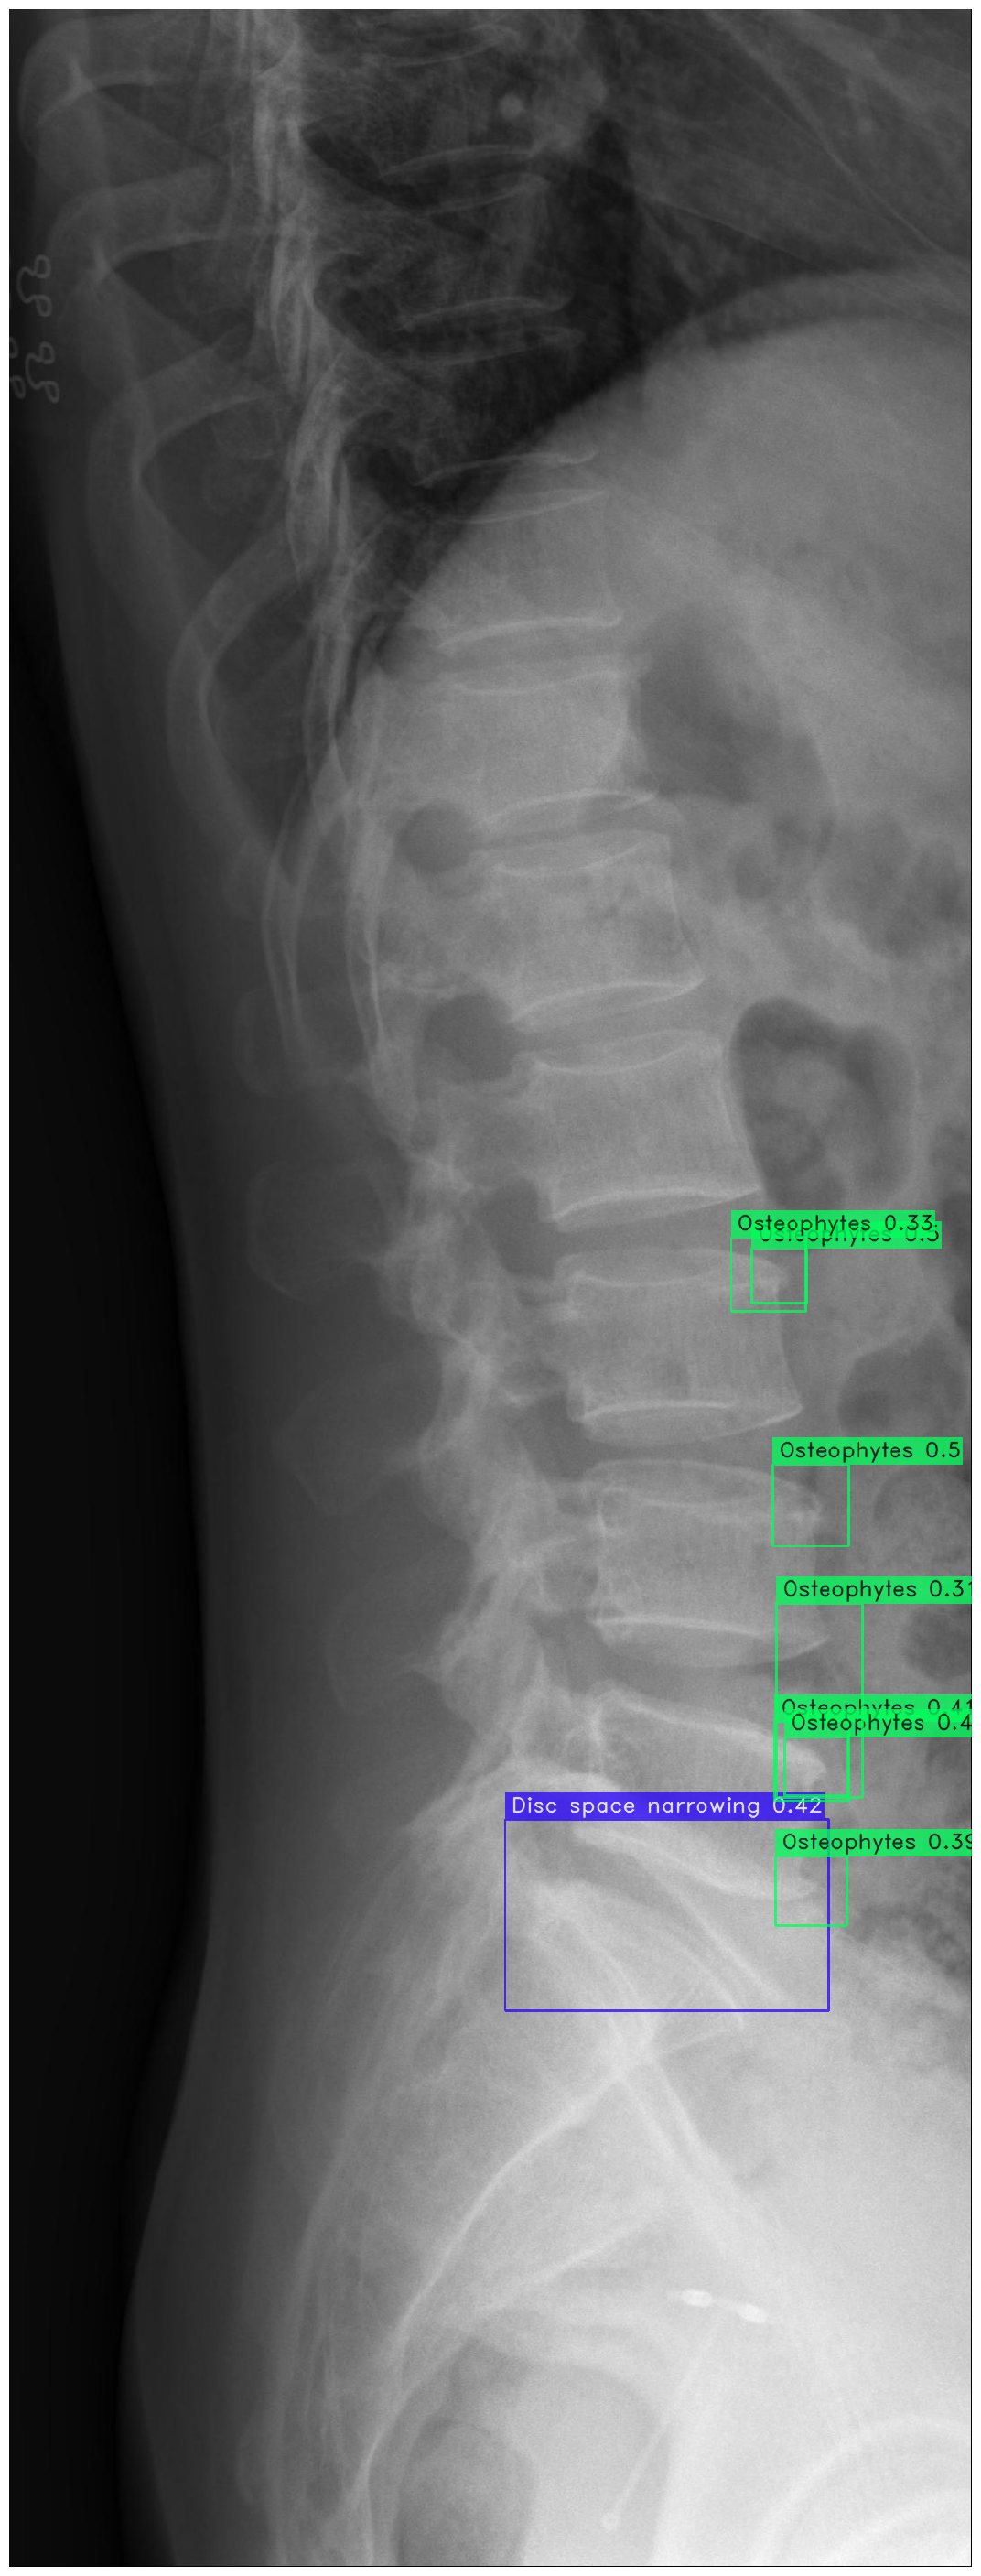

In [ ]:
img_path="/content/content/data/images/train/002c44f80a4cd39feed50e2b24327877.jpg"
model.predict(img_path, conf=0.3).show()

#Draw annonate on test-set



In [ ]:
!git clone https://github.com/waittim/draw-YOLO-box

In [ ]:
%cd /content/draw-YOLO-box

/content/draw-YOLO-box


In [ ]:
!python draw_box.py

ae7d60b0cd1c905f3188bb5ee97f1ceb
Box number: 3 Image number: 1
e6b5051c9eefa4437e14ac15360b414f
Box number: 10 Image number: 2
de56d97aedf9d5ce9352c09cebad56c3
Box number: 11 Image number: 3
e7474dde06a2e0ba74533553972fb5e8
Box number: 13 Image number: 4
aaab276a1ff83ad6cba4a62dd16aa2ed
Box number: 15 Image number: 5
c766aea8262792d5a65957625033d0f0
Box number: 20 Image number: 6
122633959f5305763874760ffc870d13
Box number: 23 Image number: 7
68fa0c10986ac9650501978c8679ff42
Box number: 24 Image number: 8
79538cb90c333410e63430b3136958cb
Box number: 31 Image number: 9
75c5c11f6c0a5cbfd17f408ad20d98e9
Box number: 35 Image number: 10
0bef4b519050b14f3505369f66bec30e
Box number: 40 Image number: 11
d8a98b4c1474d1333ec798e2f82f313f
Box number: 49 Image number: 12
0d7923bfdd60e8bcc7f7d239b6afeedd
Box number: 50 Image number: 13
9e66360831ef6efb30078a6dcee96a09
Box number: 51 Image number: 14
0befb955521627b87c6a008f6c89c181
Box number: 55 Image number: 15
0aaf18670c2baa0d9e2296e8fecc751f
Bo

In [ ]:
!cp -r /content/draw-YOLO-box/save_image /content/drive/MyDrive/AI/SpineXR